In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time
np.random.seed(121)

In [2]:
def logpdfTarget (x, covariance_inverse=None):
    if (covariance_inverse is None):
        lnp = -(1/2) * (x.T).dot(x)
    else:
        lnp = -(1/2) * (x.T).dot(covariance_inverse).dot(x)
    return(lnp)

In [3]:
d = 2
cov = np.array([1,0.9,0.9,1]).reshape(2,2)
cov_inv = np.linalg.inv(cov)
Sigma_neg = fractional_matrix_power(cov,-0.5)
Sigma_pos = fractional_matrix_power(cov,0.5)

In [64]:
begin_total = time.time()
nround = int(10e5)
burnin = int(10e3)
size = len(range(-burnin,nround))
x = np.random.random(d) - 0.5
y = np.zeros(nround*d).reshape(nround,d)
mu_star = 0.1
target_result = {}

random_1DUniform = (np.random.random(size = size*d)-0.5) * np.sqrt(12)
random_1DNormal = np.random.normal(size = size*d)
random_Normal2D = np.random.multivariate_normal(np.zeros(d),np.eye(d),size = size)
random_Square2D = np.random.uniform(-np.sqrt(3), np.sqrt(3), size = (size,2))
r = np.random.uniform(size = size)
theta = np.random.uniform(low=0.0, high=2*np.pi, size = size)
random_Disc2D = np.array([[2*np.sqrt(r[i])*np.cos(theta[i]), 2*np.sqrt(r[i])*np.sin(theta[i])] for i in range(size)])

targetset = ['N0I','N0Sigma']
kernelset_N0I = ['Gaussian2D','Square2D','Disc2D','Two1DUniform','Two1DGaussian']
kernelset_N0Sigma = ['Gaussian2D','Square2D','Disc2D','Two1DUniform','Two1DGaussian',
                    'TransGaussian2D','Two1DTransfUniform','Two1DTransfGaussian','Two1DTransfMirrorU']
sigmaset = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 1.7,
    1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
    3.0, 3.2, 3.5, 4, 4.5, 5, 6]

for target in targetset:
    kernelset = kernelset_N0I if (target == 'N0I') else kernelset_N0Sigma
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}
    for kernel in kernelset:
        cov = None if ((target == 'N0I') | ('Trans' in kernel)) else cov_inv
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = np.zeros(d)
            if ('1D' in kernel):
                for j in range(-burnin,nround):
                    if (j==0):
                        accept = np.zeros(d);
                    for i in range(d):
                        initial = x.copy()
                        pi_old = logpdfTarget(initial,cov)
                        if ('Uniform' in kernel):
                            initial[i] += random_1DUniform[(j+burnin)*d+i] * sigma    #Uniform
                        elif ('Gaussian' in kernel):
                            initial[i] += random_1DNormal[(j+burnin)*d+i] * sigma     #Gaussian
                        elif ('Mirror' in kernel):
                            NewCenter = 2*mu_star - initial[i]
                            initial[i] = NewCenter + random_1DUniform[(j+burnin)*d+i] * sigma    #Mirror Uniform
                        else:
                            sys.exit('No such kernel exists')
                        pi_new = logpdfTarget(initial,cov)
                        pi_dif = pi_new - pi_old
                        if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                            exx2 = exx2 + (np.square(initial[i]-x[i]) if i == 0 else 0)
                            x = initial
                            accept[i] += 1     
                    if (j>=0):
                        y[j,:] = np.dot(Sigma_pos,x) if ('Trans' in kernel) else x
                eff = Eff_IntegratedCorrelationTime(y[:,0])
                rho = [rho_k(y[:,0],i) for i in range(1,11)]
                Eff.append(eff)
                Pjump.append(accept[0]/nround)
                Exx2.append(exx2/nround)
                Rho.append(rho)
                Sample.append(y[:,0].copy())
                print ('Target:',target,'|Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept[0]/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
            elif('2D' in kernel):
                for j in range(-burnin,nround):
                    if (j==0):
                        accept = 0;
                    if 'Gaussian' in kernel:
                        xnew = x + random_Normal2D[j+burnin] * sigma
                    elif kernel == 'Square2D':
                        xnew = x + random_Square2D[j+burnin,:] *sigma
                    elif kernel == 'Disc2D':
                        xnew = x + random_Disc2D[j+burnin,:] *sigma
                    pi_dif = logpdfTarget(xnew,cov) - logpdfTarget(x,cov)
                    if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                        exx2 += np.square(xnew[0]-x[0])
                        x = xnew
                        accept += 1
                    if (j>=0):
                        y[j,:] = np.dot(Sigma_pos,x) if 'Trans' in kernel else x 
                eff = (Eff_IntegratedCorrelationTime(y[:,0]))
                rho = [rho_k(y[:,0],i) for i in range(1,11)]
                Eff.append(eff)
                Pjump.append(accept/nround)
                Exx2.append(exx2/nround)
                Rho.append(rho)
                Sample.append(y[:,0].copy())
                print ('Target:',target,'|Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel]
print('总共用时: %f'% (time.time()-begin_total))

Target:N0I|Kernel:Gaussian2D|sigma:0.1|eff:0.0019|Pjump:0.9504|Exx2:0.0093|rho1:0.9953|rho2:0.9907|Time:20.47
Target:N0I|Kernel:Gaussian2D|sigma:0.3|eff:0.0173|Pjump:0.8515|Exx2:0.0708|rho1:0.9648|rho2:0.9311|Time:10.46
Target:N0I|Kernel:Gaussian2D|sigma:0.5|eff:0.0408|Pjump:0.7572|Exx2:0.1622|rho1:0.9198|rho2:0.8468|Time:9.58
Target:N0I|Kernel:Gaussian2D|sigma:0.7|eff:0.0639|Pjump:0.6697|Exx2:0.2583|rho1:0.872|rho2:0.7622|Time:9.75
Target:N0I|Kernel:Gaussian2D|sigma:0.9|eff:0.0864|Pjump:0.5893|Exx2:0.3426|rho1:0.8302|rho2:0.6911|Time:9.2
Target:N0I|Kernel:Gaussian2D|sigma:1.0|eff:0.0981|Pjump:0.5523|Exx2:0.3761|rho1:0.8125|rho2:0.6629|Time:9.13
Target:N0I|Kernel:Gaussian2D|sigma:1.1|eff:0.1075|Pjump:0.5183|Exx2:0.4077|rho1:0.7993|rho2:0.6406|Time:8.85
Target:N0I|Kernel:Gaussian2D|sigma:1.3|eff:0.1214|Pjump:0.4554|Exx2:0.4507|rho1:0.7775|rho2:0.6061|Time:8.9
Target:N0I|Kernel:Gaussian2D|sigma:1.5|eff:0.1306|Pjump:0.3995|Exx2:0.4728|rho1:0.7664|rho2:0.5877|Time:8.64
Target:N0I|Kernel:Ga

Target:N0I|Kernel:Disc2D|sigma:4.5|eff:0.0303|Pjump:0.0493|Exx2:0.1497|rho1:0.9259|rho2:0.8583|Time:9.43
Target:N0I|Kernel:Disc2D|sigma:5|eff:0.0259|Pjump:0.04|Exx2:0.124|rho1:0.9388|rho2:0.8822|Time:9.0
Target:N0I|Kernel:Disc2D|sigma:6|eff:0.0172|Pjump:0.0275|Exx2:0.084|rho1:0.9583|rho2:0.919|Time:8.55
Target:N0I|Kernel:Two1DUniform|sigma:0.1|eff:0.0019|Pjump:0.9661|Exx2:0.0096|rho1:0.9951|rho2:0.9902|Time:35.73
Target:N0I|Kernel:Two1DUniform|sigma:0.3|eff:0.02|Pjump:0.8971|Exx2:0.0768|rho1:0.9618|rho2:0.9249|Time:18.24
Target:N0I|Kernel:Two1DUniform|sigma:0.5|eff:0.0482|Pjump:0.8302|Exx2:0.1884|rho1:0.9063|rho2:0.8219|Time:18.17
Target:N0I|Kernel:Two1DUniform|sigma:0.7|eff:0.0827|Pjump:0.7652|Exx2:0.3223|rho1:0.8409|rho2:0.7096|Time:16.84
Target:N0I|Kernel:Two1DUniform|sigma:0.9|eff:0.1211|Pjump:0.7039|Exx2:0.4602|rho1:0.7725|rho2:0.6026|Time:16.77
Target:N0I|Kernel:Two1DUniform|sigma:1.0|eff:0.1397|Pjump:0.6745|Exx2:0.5262|rho1:0.7402|rho2:0.5553|Time:16.38
Target:N0I|Kernel:Two1DUn

Target:N0Sigma|Kernel:Gaussian2D|sigma:2.5|eff:0.0378|Pjump:0.0995|Exx2:0.1549|rho1:0.9237|rho2:0.8535|Time:9.9
Target:N0Sigma|Kernel:Gaussian2D|sigma:2.6|eff:0.0379|Pjump:0.0942|Exx2:0.1515|rho1:0.9251|rho2:0.8561|Time:9.8
Target:N0Sigma|Kernel:Gaussian2D|sigma:2.8|eff:0.0357|Pjump:0.0834|Exx2:0.1416|rho1:0.9298|rho2:0.8649|Time:9.55
Target:N0Sigma|Kernel:Gaussian2D|sigma:3.0|eff:0.0332|Pjump:0.0751|Exx2:0.1354|rho1:0.9334|rho2:0.8716|Time:9.41
Target:N0Sigma|Kernel:Gaussian2D|sigma:3.2|eff:0.0311|Pjump:0.0678|Exx2:0.1285|rho1:0.936|rho2:0.8764|Time:9.29
Target:N0Sigma|Kernel:Gaussian2D|sigma:3.5|eff:0.0281|Pjump:0.0584|Exx2:0.1178|rho1:0.9418|rho2:0.8872|Time:9.88
Target:N0Sigma|Kernel:Gaussian2D|sigma:4|eff:0.0232|Pjump:0.0467|Exx2:0.1011|rho1:0.9499|rho2:0.9027|Time:10.74
Target:N0Sigma|Kernel:Gaussian2D|sigma:4.5|eff:0.0194|Pjump:0.0382|Exx2:0.0882|rho1:0.9566|rho2:0.915|Time:11.59
Target:N0Sigma|Kernel:Gaussian2D|sigma:5|eff:0.0168|Pjump:0.0313|Exx2:0.0754|rho1:0.9627|rho2:0.9272

Target:N0Sigma|Kernel:Two1DUniform|sigma:1.8|eff:0.0187|Pjump:0.223|Exx2:0.1143|rho1:0.9438|rho2:0.9008|Time:17.66
Target:N0Sigma|Kernel:Two1DUniform|sigma:1.9|eff:0.0169|Pjump:0.211|Exx2:0.1077|rho1:0.9465|rho2:0.9048|Time:17.97
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.0|eff:0.0157|Pjump:0.1999|Exx2:0.102|rho1:0.9494|rho2:0.9098|Time:18.37
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.1|eff:0.0154|Pjump:0.1911|Exx2:0.0977|rho1:0.9517|rho2:0.9136|Time:17.97
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.2|eff:0.0144|Pjump:0.1822|Exx2:0.0928|rho1:0.9539|rho2:0.9172|Time:18.35
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.3|eff:0.0134|Pjump:0.174|Exx2:0.0885|rho1:0.9562|rho2:0.9208|Time:18.41
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.4|eff:0.0126|Pjump:0.1674|Exx2:0.0854|rho1:0.9571|rho2:0.9223|Time:18.64
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.5|eff:0.0127|Pjump:0.1607|Exx2:0.0818|rho1:0.9595|rho2:0.9264|Time:18.23
Target:N0Sigma|Kernel:Two1DUniform|sigma:2.6|eff:0.0117|Pjump:0.1547|Exx2:0.

Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:0.1|eff:0.0023|Pjump:0.9664|Exx2:0.0096|rho1:0.995|rho2:0.9901|Time:25.69
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:0.3|eff:0.0197|Pjump:0.8973|Exx2:0.0769|rho1:0.9619|rho2:0.9252|Time:18.28
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:0.5|eff:0.0474|Pjump:0.8297|Exx2:0.1882|rho1:0.9066|rho2:0.8226|Time:17.65
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:0.7|eff:0.0834|Pjump:0.7656|Exx2:0.3224|rho1:0.8409|rho2:0.7099|Time:17.65
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:0.9|eff:0.1208|Pjump:0.7033|Exx2:0.4595|rho1:0.7727|rho2:0.603|Time:17.09
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:1.0|eff:0.1398|Pjump:0.6744|Exx2:0.5267|rho1:0.7399|rho2:0.5556|Time:16.91
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:1.1|eff:0.1584|Pjump:0.6469|Exx2:0.5906|rho1:0.7089|rho2:0.5119|Time:17.2
Target:N0Sigma|Kernel:Two1DTransfUniform|sigma:1.3|eff:0.1955|Pjump:0.5929|Exx2:0.6984|rho1:0.654|rho2:0.4381|Time:16.72
Target:N0Sigma|Kernel:Two1DT

Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:2.2|eff:0.3627|Pjump:0.4072|Exx2:1.123|rho1:0.4442|rho2:0.2122|Time:17.37
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:2.3|eff:0.3362|Pjump:0.3916|Exx2:1.0797|rho1:0.4695|rho2:0.2355|Time:16.54
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:2.4|eff:0.3145|Pjump:0.3765|Exx2:1.0285|rho1:0.4923|rho2:0.2557|Time:16.58
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:2.5|eff:0.3006|Pjump:0.3635|Exx2:0.9913|rho1:0.5115|rho2:0.2744|Time:16.2
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:2.6|eff:0.2869|Pjump:0.3499|Exx2:0.9493|rho1:0.5279|rho2:0.2912|Time:16.21
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:2.8|eff:0.2559|Pjump:0.3272|Exx2:0.8895|rho1:0.5626|rho2:0.3289|Time:16.06
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:3.0|eff:0.2386|Pjump:0.3058|Exx2:0.8274|rho1:0.5899|rho2:0.3588|Time:17.07
Target:N0Sigma|Kernel:Two1DTransfMirrorU|sigma:3.2|eff:0.2182|Pjump:0.2871|Exx2:0.7797|rho1:0.6165|rho2:0.3896|Time:17.68
Target:N0Sigma|Kernel:Two1

In [66]:
np.save('Table_S1_target_result',target_result)

In [265]:
index = [np.argmax(target_result['N0I'][0][i]) for i in kernelset_N0I]

# [target_result['N0I'][0][kernelset_N0I[i]][index[i]] for i in range(len(kernelset_N0I))]

name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernelset = kernelset_N0I if (target == 'N0I') else kernelset_N0Sigma
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax(target_result[target][0][i]) for i in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target])-1)]
        rho1 = info[3][0]; rho2 = info[3][1]
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2    
                                       N0I
Gaussian2D                1.8      0.136    0.331    0.477    0.762    0.581   
Square2D                  1.7      0.156    0.299    0.55     0.728    0.532   
Disc2D                    1.5      0.159    0.346    0.555    0.725    0.527   
Two1DUniform              2.1      0.276    0.423    0.888    0.561    0.319   
Two1DGaussian             2.4      0.232    0.442    0.751    0.626    0.392   
                                       N0Sigma
Gaussian2D                1.9      0.043    0.148    0.173    0.914    0.837   
Square2D                  1.5      0.06     0.166    0.238    0.882    0.778   
Disc2D                    1.5      0.048    0.153    0.194    0.904    0.818   
Two1DUniform              0.9      0.029    0.43     0.169    0.918    0.859   
Two1DGaussian             0.9      0.024    0.491    0.141    0.93     0.878   
TransGaussian2D           1.7 

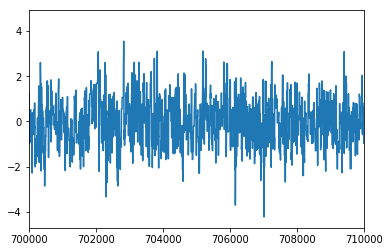

In [272]:
plt.plot(target_result['N0Sigma'][4]['Gaussian2D'][11])
plt.xlim(700000,710000)
plt.savefig('Traceplot_Gaussian2D.eps', format='eps', dpi=1000)
plt.show()

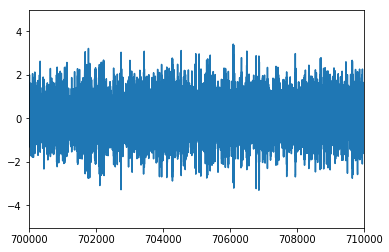

In [273]:
plt.plot(target_result['N0Sigma'][4]['Two1DTransfMirrorU'][2])
plt.xlim(700000,710000)
plt.savefig('Traceplot_Two1DTransfMirrorU.eps', format='eps', dpi=1000)
plt.show()

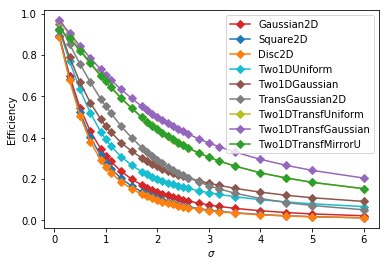

In [67]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
Pjump_kernel = target_result['N0Sigma'][1]
kernelset = list(target_result['N0Sigma'][0].keys())
[plt.plot(sigmaset,Pjump_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(9)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Pjump_N0Sigma9.eps', format='eps', dpi=1000)
plt.show()

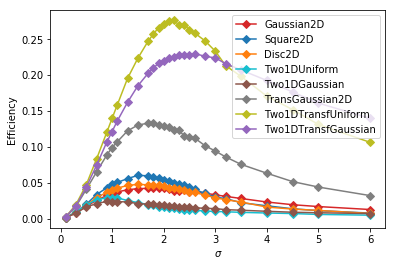

In [68]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
eff_kernel = target_result['N0Sigma'][0]
kernelset = list(target_result['N0Sigma'][0].keys())
[plt.plot(sigmaset,eff_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(8)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Eff_N0Sigma8.eps', format='eps', dpi=1000)
plt.show()

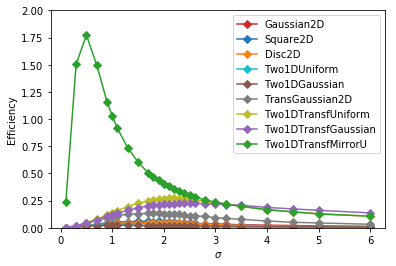

In [20]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
eff_kernel = target_result['N0Sigma'][0]
kernelset = list(target_result['N0Sigma'][0].keys())
[plt.plot(sigmaset,eff_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(9)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.ylim(0,2)
plt.savefig('Eff_N0Sigma9.eps', format='eps', dpi=1000)
plt.show()

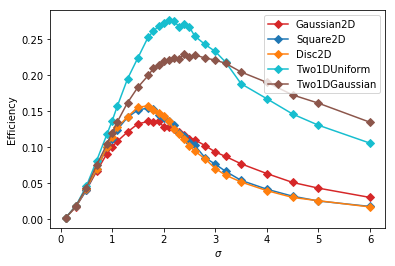

In [15]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
eff_kernel = target_result['N0I'][0]
kernelset = list(target_result['N0I'][0].keys())
[plt.plot(sigmaset,eff_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(5)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Eff_N0I.eps', format='eps', dpi=1000)
plt.show()

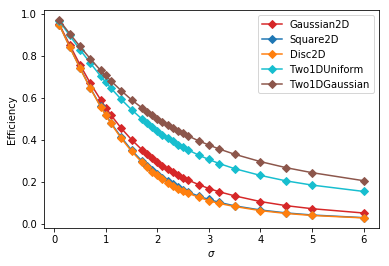

In [13]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
pjump_kernel = target_result['N0I'][1]
kernelset = list(target_result['N0I'][0].keys())
[plt.plot(sigmaset,pjump_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(5)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Pjump_N0I', format='eps', dpi=1000)
plt.show()